# Code for finding monodromy matrix of a system

In [1]:
from sympy import symbols, Matrix,re
import numpy as np
import matplotlib
import imageio.v2 as imageio
from IPython.display import Image
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sm
from sympy import symbols, Matrix
import os
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.integrate import solve_ivp

# Ligninger og løsningsmetoder

In [2]:
#Selkov model for glycolysis
def SelkovX(x,y,b,a = 0.1):
    return -x + a*y + x**2*y

def SelkovY(x,y,b,a = 0.1):
    return b - a*y - x**2*y


#Supercritical hopf bifurcation
def x_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*x-w*y #normalformen for superkritiske hopf.
def y_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*y+w*x

#Solutions to the supercritcal hopf bifurcation
def solution_supercrit_Pol(t,mu,w,r0): #Polar coordinates
    C = (r0**2-mu)/(r0**2)
    T = 2*mu*t
    return (mu/(1-C*np.exp(-T)))**0.5

def solution_supercritTheta(t,w,theta0): #Theta, lidt ligegyldig
    return w*t +theta0

def solution_supercrit_Cart(t, mu,w, x0, y0): #Cartesian coordinates
    #theta = np.arctan2(y0,x0)
    return np.cos(w*t)*solution_supercrit_Pol(t, mu, w, x0), np.sin(w*t)*solution_supercrit_Pol(t, mu, w, y0) #x(t) and y(t)


#Van Der Pol

def VanX(x,y,mu,w):
    return y
def VanY(x,y,mu,w):
    return mu*(1-x**2)*y-x

def intgrator_rk4(func_x,func_y,dt,x,y,paramsx,paramsy): #Input function, timestep, coordinates and finally params as [...,...,...]
    
    k1x = func_x(x,y,*paramsx)*dt
    k1y = func_y(x,y,*paramsy)*dt
    
    k2x = func_x(x+0.5*k1x, y+0.5*k1y, *paramsx)*dt
    k2y = func_y(x+0.5*k1x, y+0.5*k1y, *paramsy)*dt
    
    k3x = func_x(x+0.5*k2x, y+0.5*k2y, *paramsx)*dt
    k3y = func_y(x+0.5*k2x, y+0.5*k2y, *paramsy)*dt
    
    k4x = func_x(x+k3x,y+k3y, *paramsx)*dt
    k4y = func_y(x+k3x,y+k3y, *paramsy)*dt
    
    xnew = x + 1./6*(k1x+2*k2x+2*k3x+k4x)
    ynew = y + 1./6*(k1y+2*k2y+2*k3y+k4y)

    return xnew, ynew

# Generelle funktioner

In [3]:
def jacobian(v1, v2, x_val, y_val):
    # Create the vector field
    x, y = symbols('x y')

    vector_field = Matrix([v1, v2])
    
    # Define the variables
    variables = Matrix([x, y])
    
    # Compute the Jacobian matrix
    jacobian_matrix = vector_field.jacobian(variables)
    
    jacobian_matrix_evaluated = jacobian_matrix.subs({x: x_val, y: y_val})
    numpy_matrix = np.array(jacobian_matrix_evaluated.evalf()).astype(np.float64)
    return numpy_matrix

def LC_coords(xmap,ymap,functionx,functiony,params,runtime,converging_time,dt,dt_conv):
        time_converg = 0
        time_data = 0
        mu,w = params
        running = True
        listsize = int(runtime / dt)
        limitx = np.zeros(listsize*5)
        limity = np.zeros(listsize*5)
        index = 0
        dtr = dt_conv
        while running:
            xmap, ymap = intgrator_rk4(functionx, functiony, dtr, xmap, ymap, [mu,w], [mu,w])
            if time_converg < converging_time:
                time_converg += dtr
            else:
                dtr = dt
                time_data += dtr
                limitx[index] = xmap
                limity[index] = ymap
                index +=1
                if time_data > runtime:
                    running = False
        limitx,limity = np.array(limitx),np.array(limity)
        return limitx[:index],limity[:index]

def LC_period(xmap, ymap, functionx, functiony, params, runtime, converging_time, dt, round = True,tol=1e-3, section_plane='y', threshold=0):
    limitcoords = LC_coords(xmap, ymap, functionx, functiony, params, runtime, converging_time, dt,dt)
    x,y = limitcoords
    times_crossing = []
    index  = np.array(limitcoords[0]).argmin()
    if round:
        for i in range(1, len(limitcoords[0])):
            x_prev, y_prev = limitcoords[0][i-1], limitcoords[1][i-1]
            x_curr, y_curr = limitcoords[0][i], limitcoords[1][i]
            if section_plane == 'y':
                if (y_prev < threshold <= y_curr):  # Crosses y=0 plane upwards
                    times_crossing.append(i)
                        
            elif section_plane == 'x':
                if (x_prev < threshold <= x_curr):  # Crosses x=0 plane upwards
                    times_crossing.append(i)
    else:
        prev_sign = np.sign(y[0] - y[index])  # Compare previous X with mu
        for i, (X,Y) in enumerate(zip(x,y)):  
            current_sign = np.sign(Y - y[index])  # Compare current X with mu
            if prev_sign < 0 and current_sign >= 0:# or i==0:
                times_crossing.append(i)            
            prev_sign = current_sign  # 

    # Calculate period as the difference between successive crossings
    if len(times_crossing) >= 1:
        period = np.mean(np.diff(times_crossing)*dt)  # Estimate average period
        return period, limitcoords
    else:
        plt.plot(limitcoords[0],limitcoords[1])
        print(times_crossing)
        raise ValueError("No crossings detected in the given runtime.")


def make_gif(filelog,gif_name,display_length):
    with imageio.get_writer(f'{gif_name}.gif', mode='I', duration=display_length, loop = 0) as writer: #Creating the gif
        for filename in filelog:
            image = imageio.imread(filename)
            writer.append_data(image)
    for filename in filelog: #Removing the temporary images
        os.remove(filename)
        
def SuperCrit(t, x, mu):
    x1, x2 = x
    dx1dt = (mu-x1**2-x2**2)*x1-x2
    dx2dt = (mu-x1**2-x2**2)*x2+x1
    return [dx1dt, dx2dt]

def jacobian_SuperCrit(t, x, mu):
    x1, x2 = x
    return np.array([[(mu-3*x1**2-x2**2), -1-2*x1*x2],
                     [1-2*x1*x2, (mu-x1**2-3*x2**2)]])

def variational_eq_super(t, y, mu):
    # y contains the state vector thing and the flattened Phi matrix
    x = y[:2]
    Phi = y[2:].reshape(2, 2)
    
    A = jacobian_SuperCrit(t, x, mu)
    
    dPhi_dt = A @ Phi #Basically taking the matrix product of Jacobian and the Phi matrix which becomes monodromy after a period
    
    # Return the time derivatives of the state and Phi(t) together
    return np.concatenate([SuperCrit(t, x, mu), dPhi_dt.flatten()])

def vdp(t, x, mu):
    x1, x2 = x
    dx1dt = x2
    dx2dt = mu * (1 - x1**2) * x2 - x1
    return [dx1dt, dx2dt]

def jacobian_VDP(t, x, mu):
    x1,x2 = x
    x,y = symbols ('x y')
    return jacobian(VanX(x,y,mu,1),VanY(x,y,mu,1),x1,x2) 

def jacobian_SELKOV(t,x,mu,a=0.1):
    x1,x2 = x
    return np.array([[-1+2*x1*x2, a+x1**2],
                     [-2*x1*x2, -a-x1**2]])
    #return jacobian(SelkovX(x,y,b,a),SelkovY(x,y,b,a),x0,y0)
def selkov(t,x,b,a=0.1):
    x1,x2 = x
    #dx1dt = -x1 +a*x2 +x1**2*x2
    #dx2dt = b -a*x2 -x1**2*x2
    #return [dx1dt, dx2dt]
    return [SelkovX(x1,x2,b,a),SelkovY(x1,x2,b,a)]
def variational_eq_selkov(t,y,b,a=0.1):
    x = y[:2]
    Phi = y[2:].reshape(2, 2)
    
    A = jacobian_SELKOV(t,x, b,a)
    
    dPhi_dt = A @ Phi
    
    return np.concatenate([selkov(t, x, b,a), dPhi_dt.flatten()])

# Forsøg med egenværdier (Floquet)

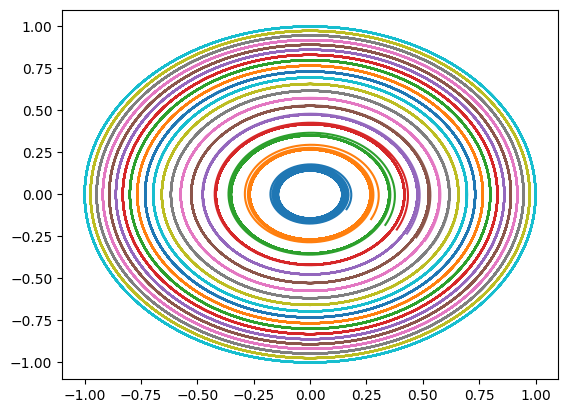

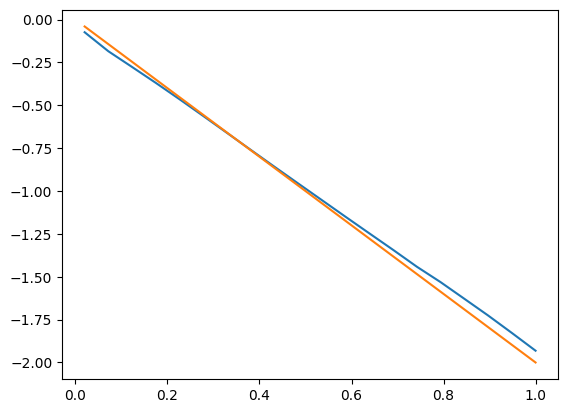

In [19]:

def variational_eq_vdp(t, y, mu):
    x = y[:2]
    Phi = y[2:].reshape(2, 2)
    
    A = jacobian_VDP(t, x, mu)
    
    dPhi_dt = A @ Phi
    
    return np.concatenate([vdp(t, x, mu), dPhi_dt.flatten()])


def monodromy_eigs(mu,funcx,funcy):
    if funcx == VanX:
        varitional = variational_eq_vdp
        scipyfunc = vdp
        w = 1
    elif funcx == x_supercrit:
        varitional = variational_eq_super
        scipyfunc = SuperCrit
        w = 1
    elif funcx == SelkovX:
        varitional = variational_eq_selkov 
        scipyfunc = selkov
        w = 0.1
    T,limitcoord = LC_period(np.sqrt(mu),np.sqrt(mu), funcx, funcy, [mu, w], runtime=100, converging_time=5, dt=0.001, round = False)
    x0 = limitcoord[0][0], limitcoord[1][0]  
    sol = solve_ivp(scipyfunc, [0, T], x0, args=(mu,), dense_output=True)
    Phi0 = np.eye(2).flatten()
    plt.plot(limitcoord[0],limitcoord[1])
    y0 = np.concatenate([x0, Phi0])

    sol_variation = solve_ivp(varitional, [0, T], y0, args=(mu,), dense_output=False)

    Phi_T = sol_variation.y[2:, -1].reshape(2, 2)
    eigs = np.linalg.eig(Phi_T)[0]
    return eigs,T

def mugif(mu,funcx,funcy):
    filenames = []
    L = 1
    x,y = np.linspace(-L,L,4000), np.linspace(-L,L,4000)
    X,Y = np.meshgrid(x,y)
    mask = np.isclose(X**2 + Y**2, L**2, atol=0.2e-3)
    w,y = X[mask], Y[mask]
    Tlist = []
    for i in mu:
        eigs,T= monodromy_eigs(i,funcx,funcy)
        fig, ax = plt.subplots()
        #plt.xlim(0.25,1.01)#0.98,1.01)
        plt.ylim(-0.1,0.1)
        ax.plot(eigs.real, eigs.imag, 'ro', label = 'Eigenvalues')
        ax.plot(X[mask], Y[mask], 'b.', label = 'Unit circle')
        filenamex = f'temp_plot_{i}_x.png'
        plt.title(f'Eigenvalues of the monodromy matrix,Van der pol, $\mu = {i:.5f}$')
        plt.xlabel('Real part')
        plt.ylabel('Imaginary part')
        plt.legend(loc = 'upper right')
        plt.savefig(filenamex, bbox_inches = 'tight', pad_inches = 0.1)
        filenames.append(filenamex)
        plt.close()
        Tlist.append(T)
        print(eigs.real,T)
    make_gif(filenames,'test',display_length=2)
    return Tlist
mulist = np.linspace(0.02,1,20)
eiglist = np.zeros_like(mulist)
#Tlist = mugif(mulist,x_supercrit,y_supercrit)
for j,mu in enumerate(mulist):
    eigs,T = monodromy_eigs(mu,x_supercrit,y_supercrit)
    eiglist[j]=1/T*np.log(eigs.real)[0]
plt.show()
plt.plot(mulist,eiglist)
plt.plot(mulist,-2*mulist)

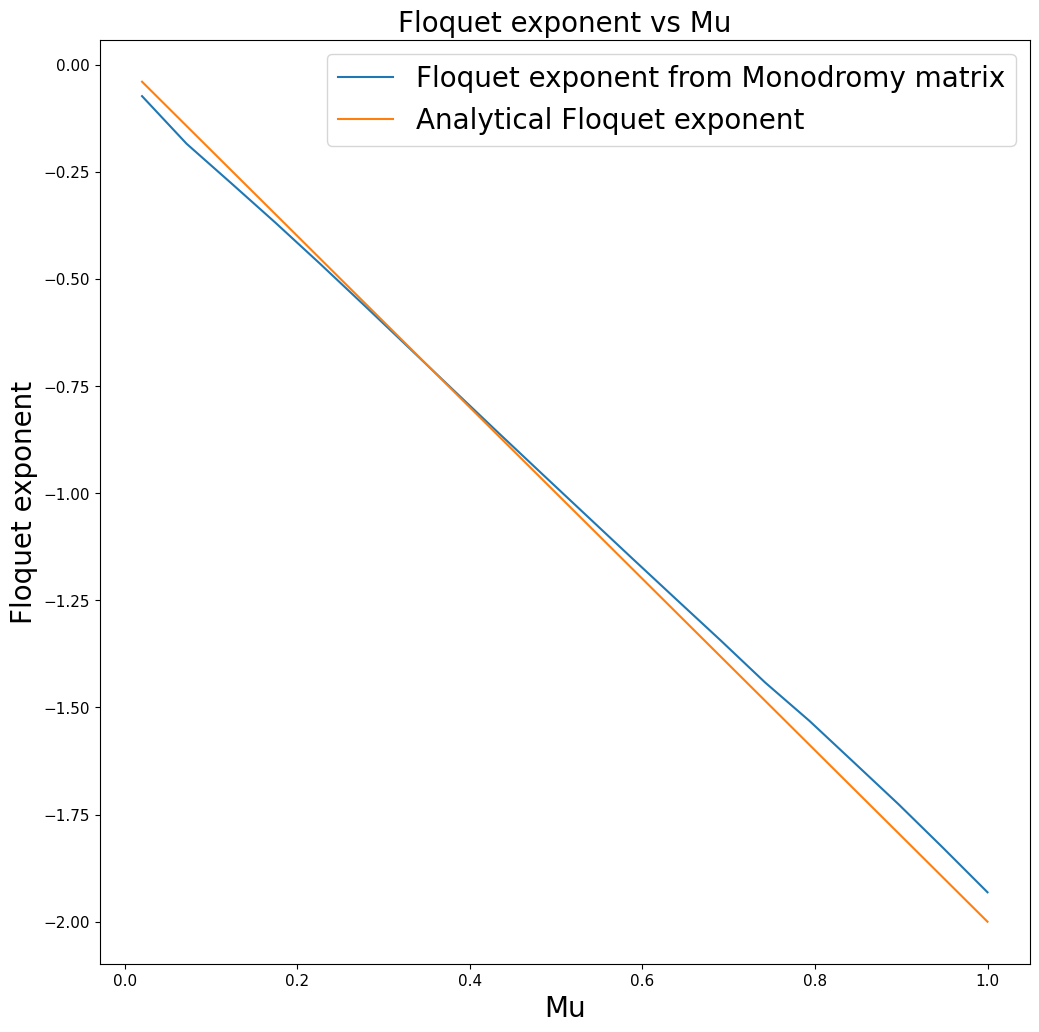

In [22]:
plt.rcParams['figure.figsize'] = [12, 12]

plt.plot(mulist,eiglist, label = 'Floquet exponent from Monodromy matrix')
plt.plot(mulist,-2*mulist, label = "Analytical Floquet exponent") 
plt.xlabel('Mu',fontsize = 20)
plt.ylabel('Floquet exponent',fontsize = 20)
plt.legend(fontsize = 20)
plt.title('Floquet exponent vs Mu',fontsize = 20)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

In [11]:
T,limitcoord = LC_period(1, 1.5, SelkovX, SelkovY, [0.425, 0.1], runtime=1000, converging_time=200, dt=0.001, round = False)
print(T,2*np.pi)


11.872964285714291 6.283185307179586


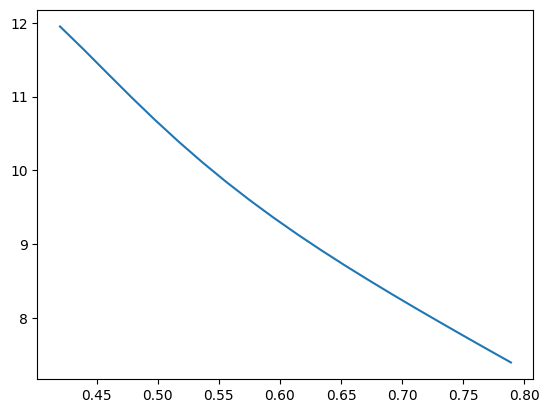

In [14]:
plt.plot(mulist,Tlist)

In [30]:

def monodromy_eigs(mu):
    T = LC_period(np.sqrt(mu), 0, x_supercrit, y_supercrit, [mu, 1], runtime=1000, converging_time=10, dt=0.001)

    x0 = [np.sqrt(mu), 0.0]  #Start point of LC

    sol = solve_ivp(vdp, [0, T], x0, args=(mu,), dense_output=True)

    Phi0 = np.eye(2).flatten()

    #ombined initial condition (state + Phi(0))
    y0 = np.concatenate([x0, Phi0])

    #  Monodromy calculated from t = 0 to t = T
    sol_variation = solve_ivp(variational_eq_super, [0, T], y0, args=(mu,), dense_output=False)

    # Extract the monodromy matrix (Phi(T))
    Phi_T = sol_variation.y[2:, -1].reshape(2, 2)
    eigs = np.linalg.eig(Phi_T)[0]
    return eigs

def mugif_super(mu):
    filenames = []
    L = 1
    x,y = np.linspace(-L,L,10000), np.linspace(-L,L,10000)
    X,Y = np.meshgrid(x,y)
    mask = np.isclose(X**2 + Y**2, L**2, atol=0.2e-3)
    w,y = X[mask], Y[mask]
    for i in mu:
        eigs= monodromy_eigs(i)
        fig, ax = plt.subplots()
        #plt.xlim(0.98,1.01)
        #plt.ylim(-0.0025,0.0025)
        ax.plot(eigs.real, eigs.imag, 'ro', label = 'Eigenvalues')
        ax.plot(X[mask], Y[mask], 'b.', label = 'Unit circle')
        filenamex = f'temp_plot_{i}_x.png'
        plt.title(f'Eigenvalues of the monodromy matrix,Super, $\mu = {i:.5f}$')
        plt.xlabel('Real part')
        plt.ylabel('Imaginary part')
        plt.legend(loc = 'upper right')
        plt.savefig(filenamex, bbox_inches = 'tight', pad_inches = 0.1)
        filenames.append(filenamex)
        plt.close()
    make_gif(filenames,'Test',display_length=2)
mulist = np.linspace(0.001,0.004,20)
mugif_super(mulist)

filenamex = []
filenames = []
mulist = np.linspace(0.0001,0.001,20)

x = np.linspace(-2.2,2.2,1000)
y = np.linspace(-2.2,2.2,1000)
X,Y = np.meshgrid(x,y)

P = 50



for mu in mulist:
    fig, ax = plt.subplots()
    limitcoords = LC_coords(2, 0, VanX, VanY, [mu, 1], runtime=1000, converging_time=10, dt_conv = 0.05,dt=0.0005)
    ax.plot(limitcoords[0], limitcoords[1],label = 'Limit cycle')
    xdot = VanX(X,Y,mu,1)
    ydot = VanY(X,Y,mu,1)
    magnitude = np.sqrt(xdot**2 + ydot**2)
    xdot_normalized = xdot / magnitude
    ydot_normalized = ydot / magnitude
    ax.quiver(X[::P, ::P], Y[::P, ::P], xdot_normalized[::P, ::P], ydot_normalized[::P, ::P],
         pivot='mid', units='inches')
    filenamex = f'temp_plot_{mu}_x.png'
    plt.title(f'Phase diagram of Van Der Pol, $\mu = {mu:.5f}$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc = 'upper right')
    plt.savefig(filenamex, bbox_inches = 'tight', pad_inches = 0.1)
    filenames.append(filenamex)
    plt.close()
make_gif(filenames,'Phase_VDP',display_length=2)
